### Install Runhouse

In [ ]:
!pip install runhouse

In [1]:
import runhouse as rh

### Login to Runhouse to load in secrets.

In [ ]:
# You can add token=<your token> if you want to be able to run this without pasting into stdin
rh.login(download_secrets=True, download_config=True, interactive=True)

In [ ]:
# Only if you're using GCP and running inside Colab!
!gcloud init
!gcloud auth application-default login
!cp -r /content/.config/* ~/.config/gcloud

In [ ]:
# Check that secrets are loaded in properly and at least one cloud is ready to use.
!sky check

##  Calling in our existing Stable Diffusion service

Now that we've created and saved our sd_generate Send in the previous tutorial, we can load and call into it natively.

(_Note: if you didn't run tutorial p01 to create the Stable Diffusion service, you can jump to the appendix of this notebook to create it there._)

In [6]:
generate_gpu = rh.send(name='sd_generate')

INFO | 2023-01-16 08:23:31,714 | Running sd_generate via SSH
INFO | 2023-01-16 08:23:55,509 | Time to send message: 12.78 seconds


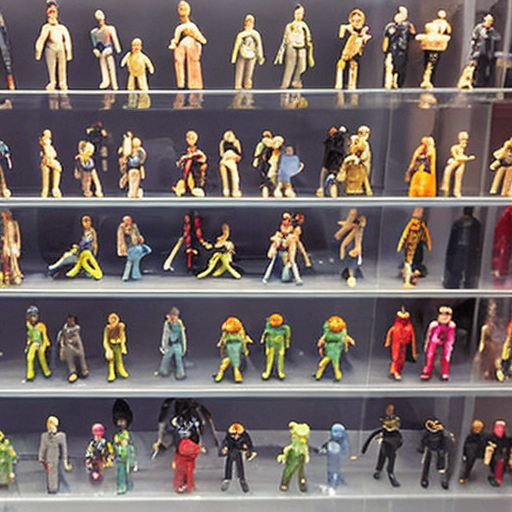

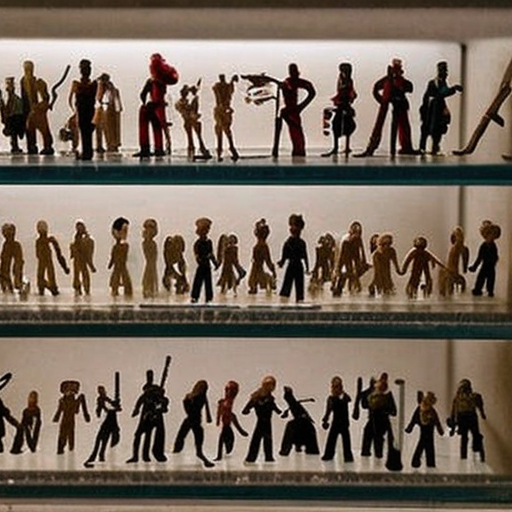

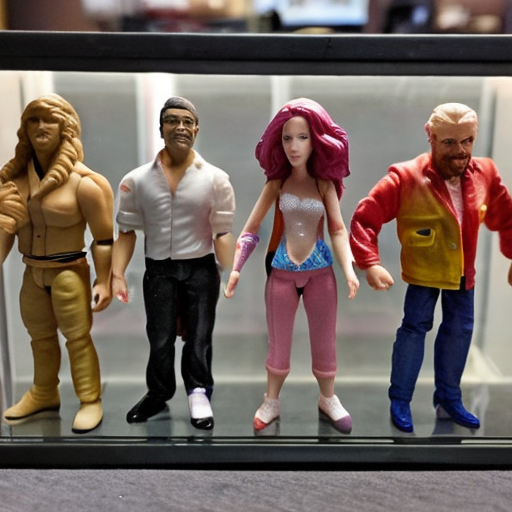

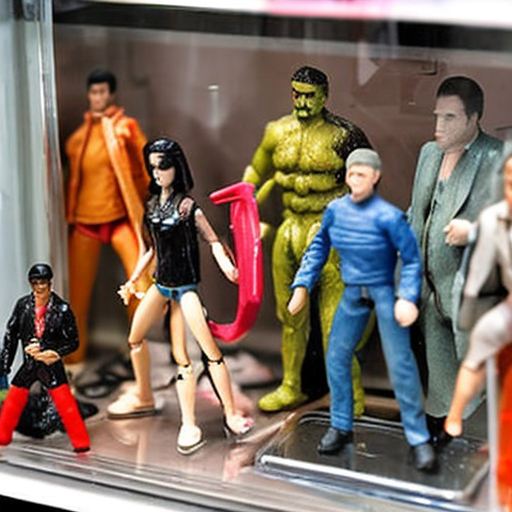

[None, None, None, None]

In [8]:
af_prompt = 'A display case of action figures modelled after various people who might be standing in line for the bathroom at a concert.'
images = generate_gpu(af_prompt, num_images=4, steps=50)
[display(image) for image in images]

### Notes on Notebooks

Notebooks are very strange Python environments. When we create a Send in Runhouse, we sync over the local code to the cluster so the appropriate function can be imported and run. But functions can't be imported from notebooks, so when you define a Send inside a notebook, we need to write your function to a one-off module. One quirk of doing so is that functions which are defined in notebooks cannot include outside variables or closures, as those won't be written to this module. You need to include all variables and imports inside the function. 

Note that we don't have the above issues if you import the function you're Sending from a Python module outside the notebook.

Generally we advise you to define your functions and Sends in standard Python, such as a shared team repo or package, and avoid defining them in notebooks. You can even define your Sends from your local environment and then play with them inside the notebook, as we did above. Your notebooks will look much cleaner to not include big function blocks, and others will be able to import and use your functions.

# Creating a GPT-2 Send

In any event, here's how we can send a new function to our existing cluster (or a new cluster) from inside a notebook. And let's have some fun doing it. Writing prompts is hard, so let's create a service which runs GPT-2 to generate text, and then use the output to feed into our Stable Diffusion service from above and tutorial p01.

In [10]:
def gpt_2_generate(prompt, max_length=30, num_return_sequences=5, model_id='gpt2'):
    from transformers import pipeline, set_seed
    generator = pipeline('text-generation', model=model_id)
    return generator(prompt, max_length=max_length, num_return_sequences=num_return_sequences)

In [12]:
generate_gpt_2 = rh.send(fn=gpt_2_generate,
                          hardware=generate_gpu.hardware.rns_address,
                          reqs=['./', 'torch==1.12.0', 'transformers'],
                          name='generate_gpt_2')

# Not exactly sure why, but you may also need to uncomment this to upgrade transformers from the one that was installed for our SD send.
# generate_gpt_2.hardware.run(['pip install --upgrade transformers'])

INFO | 2023-01-16 08:26:10,769 | Writing out send function to /content/generate_gpt_2_fn.py as functions serialized in notebooks are brittle. Please make sure the function does not rely on any local variables, including imports (which should be moved inside the function body).


Output()

Output()

INFO | 2023-01-16 08:26:45,831 | Setting up Send on cluster.
INFO | 2023-01-16 08:26:56,842 | Copying local package None to cluster <rh-v100>
INFO | 2023-01-16 08:26:57,237 | Installing packages on cluster rh-v100: ['./', 'torch==1.12.0', 'transformers']
INFO | 2023-01-16 08:27:00,357 | Send setup complete.


In [22]:
gpt2_predictions = generate_gpt_2(prompt="An oil painting of", num_return_sequences=5, max_length=30)
gpt2_predictions

INFO | 2023-01-16 08:32:08,362 | Running generate_gpt_2 via SSH
INFO | 2023-01-16 08:32:12,568 | Time to send message: 4.2 seconds


[{'generated_text': "An oil painting of the world's tallest building. By the time its erection in 2008, Japan was just three-tenths of an inch high"},
 {'generated_text': 'An oil painting of the sun as it moves on the sea on the beach in Lampedusa, Italy in this April 4, 2008 file photo.'},
 {'generated_text': 'An oil painting of the French-Canadian war in which French soldiers are seen laying siege to Fort du Sud-de-Loup in the North.'},
 {'generated_text': 'An oil painting of a girl, on horseback: The girl wearing the dress, by artist Georges Bloomsbury.\n\nA view'},
 {'generated_text': 'An oil painting of an older girl with the name of Traviello. (Photo: David McNew/Getty Images)\n\n"He'}]

An oil painting of a girl, on horseback: The girl wearing the dress, by artist Georges Bloomsbury.

A view
INFO | 2023-01-16 08:33:07,799 | Running sd_generate via SSH
INFO | 2023-01-16 08:33:20,142 | Time to send message: 12.34 seconds


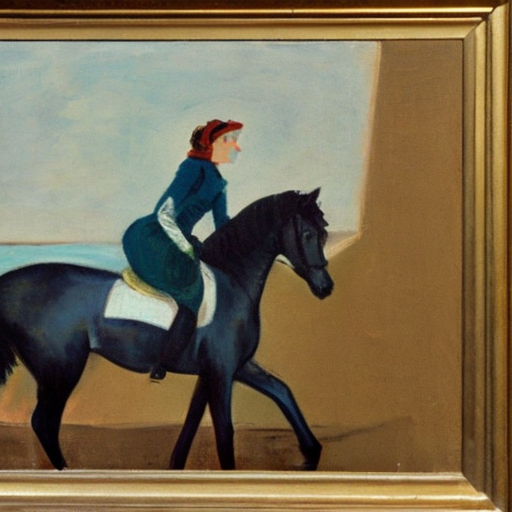

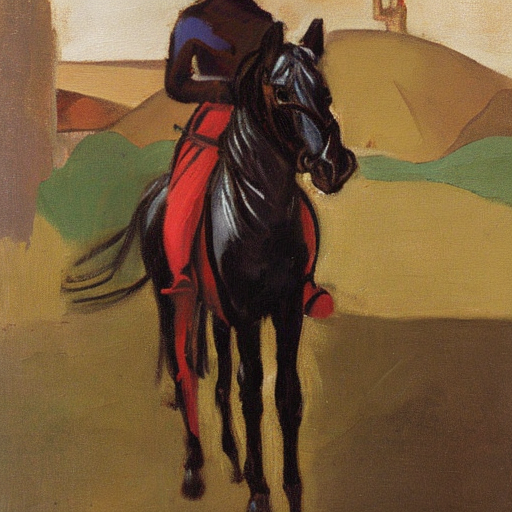

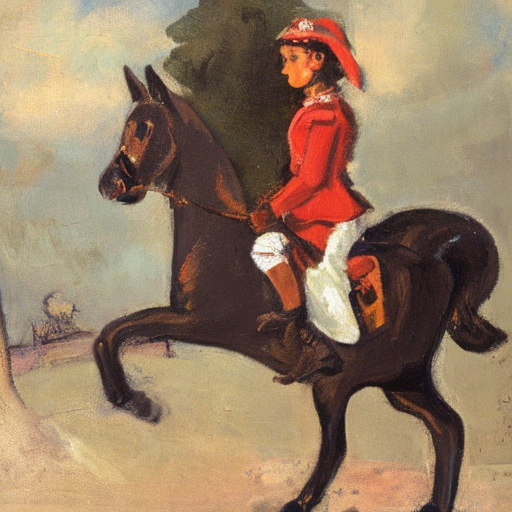

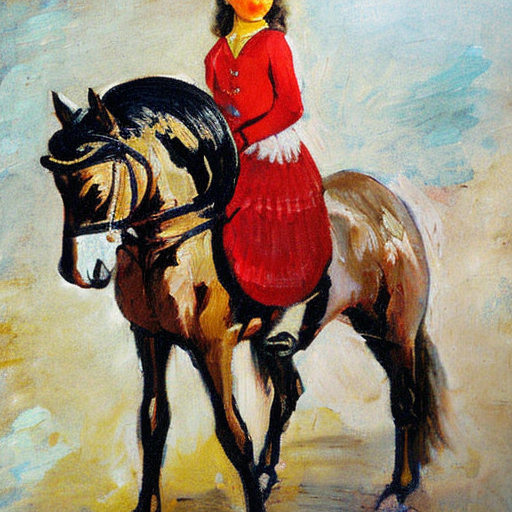

[None, None, None, None]

In [24]:
# Now pick a prompt from the above to feed into our SD service!
gpt2_prompt = gpt2_predictions[3]['generated_text']
print(gpt2_prompt)

gpt_2_images = generate_gpu(gpt2_prompt, num_images=4, steps=50)
[display(image) for image in gpt_2_images]

# Cleaning up

Cluster auto-termination is enabled by default (after 30 minutes of inactivity), but you can also terminate in your cloud provider's UI, or through Runhouse as follows:

In [ ]:
# generate_gpu.hardware.teardown()

If instead you'd like to suspend auto-termination entirely:

In [28]:
generate_gpu.keep_warm(autostop_mins=-1)

## Appendix: Creating the Stable Diffusion service, if you skipped or couldn't run tutorial p01.

In [ ]:
def sd_generate(prompt, num_images=1,
                steps=100, guidance_scale=7.5,
                model_id='stabilityai/stable-diffusion-2-base'):
    from diffusers import StableDiffusionPipeline
    import torch
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision='fp16').to('cuda')
    return pipe([prompt] * num_images, num_inference_steps=steps, guidance_scale=guidance_scale).images

In [ ]:
gpu = rh.cluster(name='rh-v100', instance_type='V100:1')
generate_gpu = rh.send(fn=sd_generate,
                       hardware=gpu, 
                       reqs=['./', 'torch==1.12.0', 'diffusers', 'transformers'],
                       name='sd_generate')

In [25]:
rh_logo_prompt = 'A digital illustration of a woman running on the roof of a house.'
rh_logo_images = generate_gpu(rh_logo_prompt, num_images=2, steps=50, guidance_scale=9)

INFO | 2023-01-16 08:35:40,034 | Running sd_generate via SSH
INFO | 2023-01-16 08:35:48,275 | Time to send message: 8.23 seconds


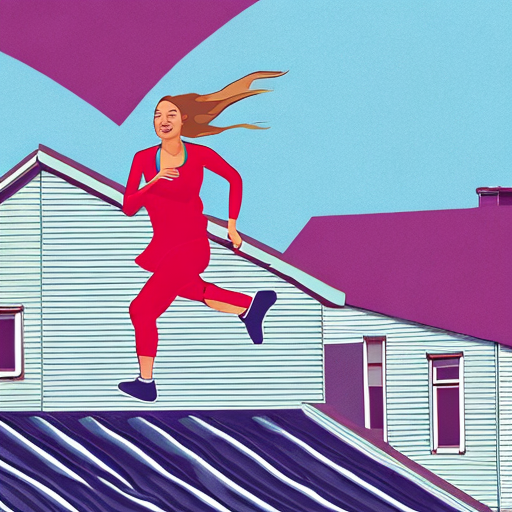

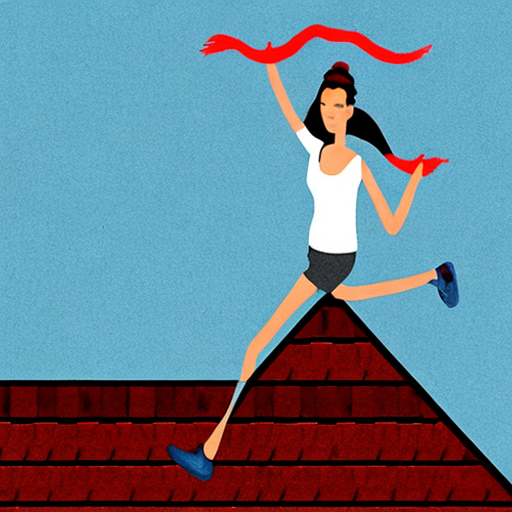

[None, None]

In [ ]:
[display(image) for image in rh_logo_images]